In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from fbprophet import Prophet


%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
plant1_generation = pd.read_csv('../input/solar-power-generation-data/Plant_1_Generation_Data.csv')
plant1_weather = pd.read_csv('../input/solar-power-generation-data/Plant_1_Weather_Sensor_Data.csv')
plant2_generation = pd.read_csv('../input/solar-power-generation-data/Plant_2_Generation_Data.csv')
plant2_weather = pd.read_csv('../input/solar-power-generation-data/Plant_2_Weather_Sensor_Data.csv')

In [4]:
plant1_generation.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [5]:
plant2_weather.tail()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
3254,2020-06-17 22:45:00,4136001,iq8k7ZNt4Mwm3w0,23.511703,22.856201,0.0
3255,2020-06-17 23:00:00,4136001,iq8k7ZNt4Mwm3w0,23.482282,22.744190,0.0
3256,2020-06-17 23:15:00,4136001,iq8k7ZNt4Mwm3w0,23.354743,22.492245,0.0
3257,2020-06-17 23:30:00,4136001,iq8k7ZNt4Mwm3w0,23.291048,22.373909,0.0
3258,2020-06-17 23:45:00,4136001,iq8k7ZNt4Mwm3w0,23.202871,22.535908,0.0


# Questions
- Can we predict the power generation for next couple of days? - this allows for better grid management

We can try, I'm inclined to use fbprophet for this as we have weekly data

- Can we identify the need for panel cleaning/maintenance?
- Can we identify faulty or suboptimally performing equipment?

I feel like these two questions go together. The way to identify a need for maintenance or fault detection is to build a trend of normal system performance (power output) in a given set of environmental conditions (time of day, weather etc). Any fall in power output indicates a need for maintenance/cleaning or the occurance of a fault. As we only have a month of data, this will be challenging to do properly...but hey, we can show how it would be done

# Visualisation

Lets look at the data and see if anything can be gleaned from it

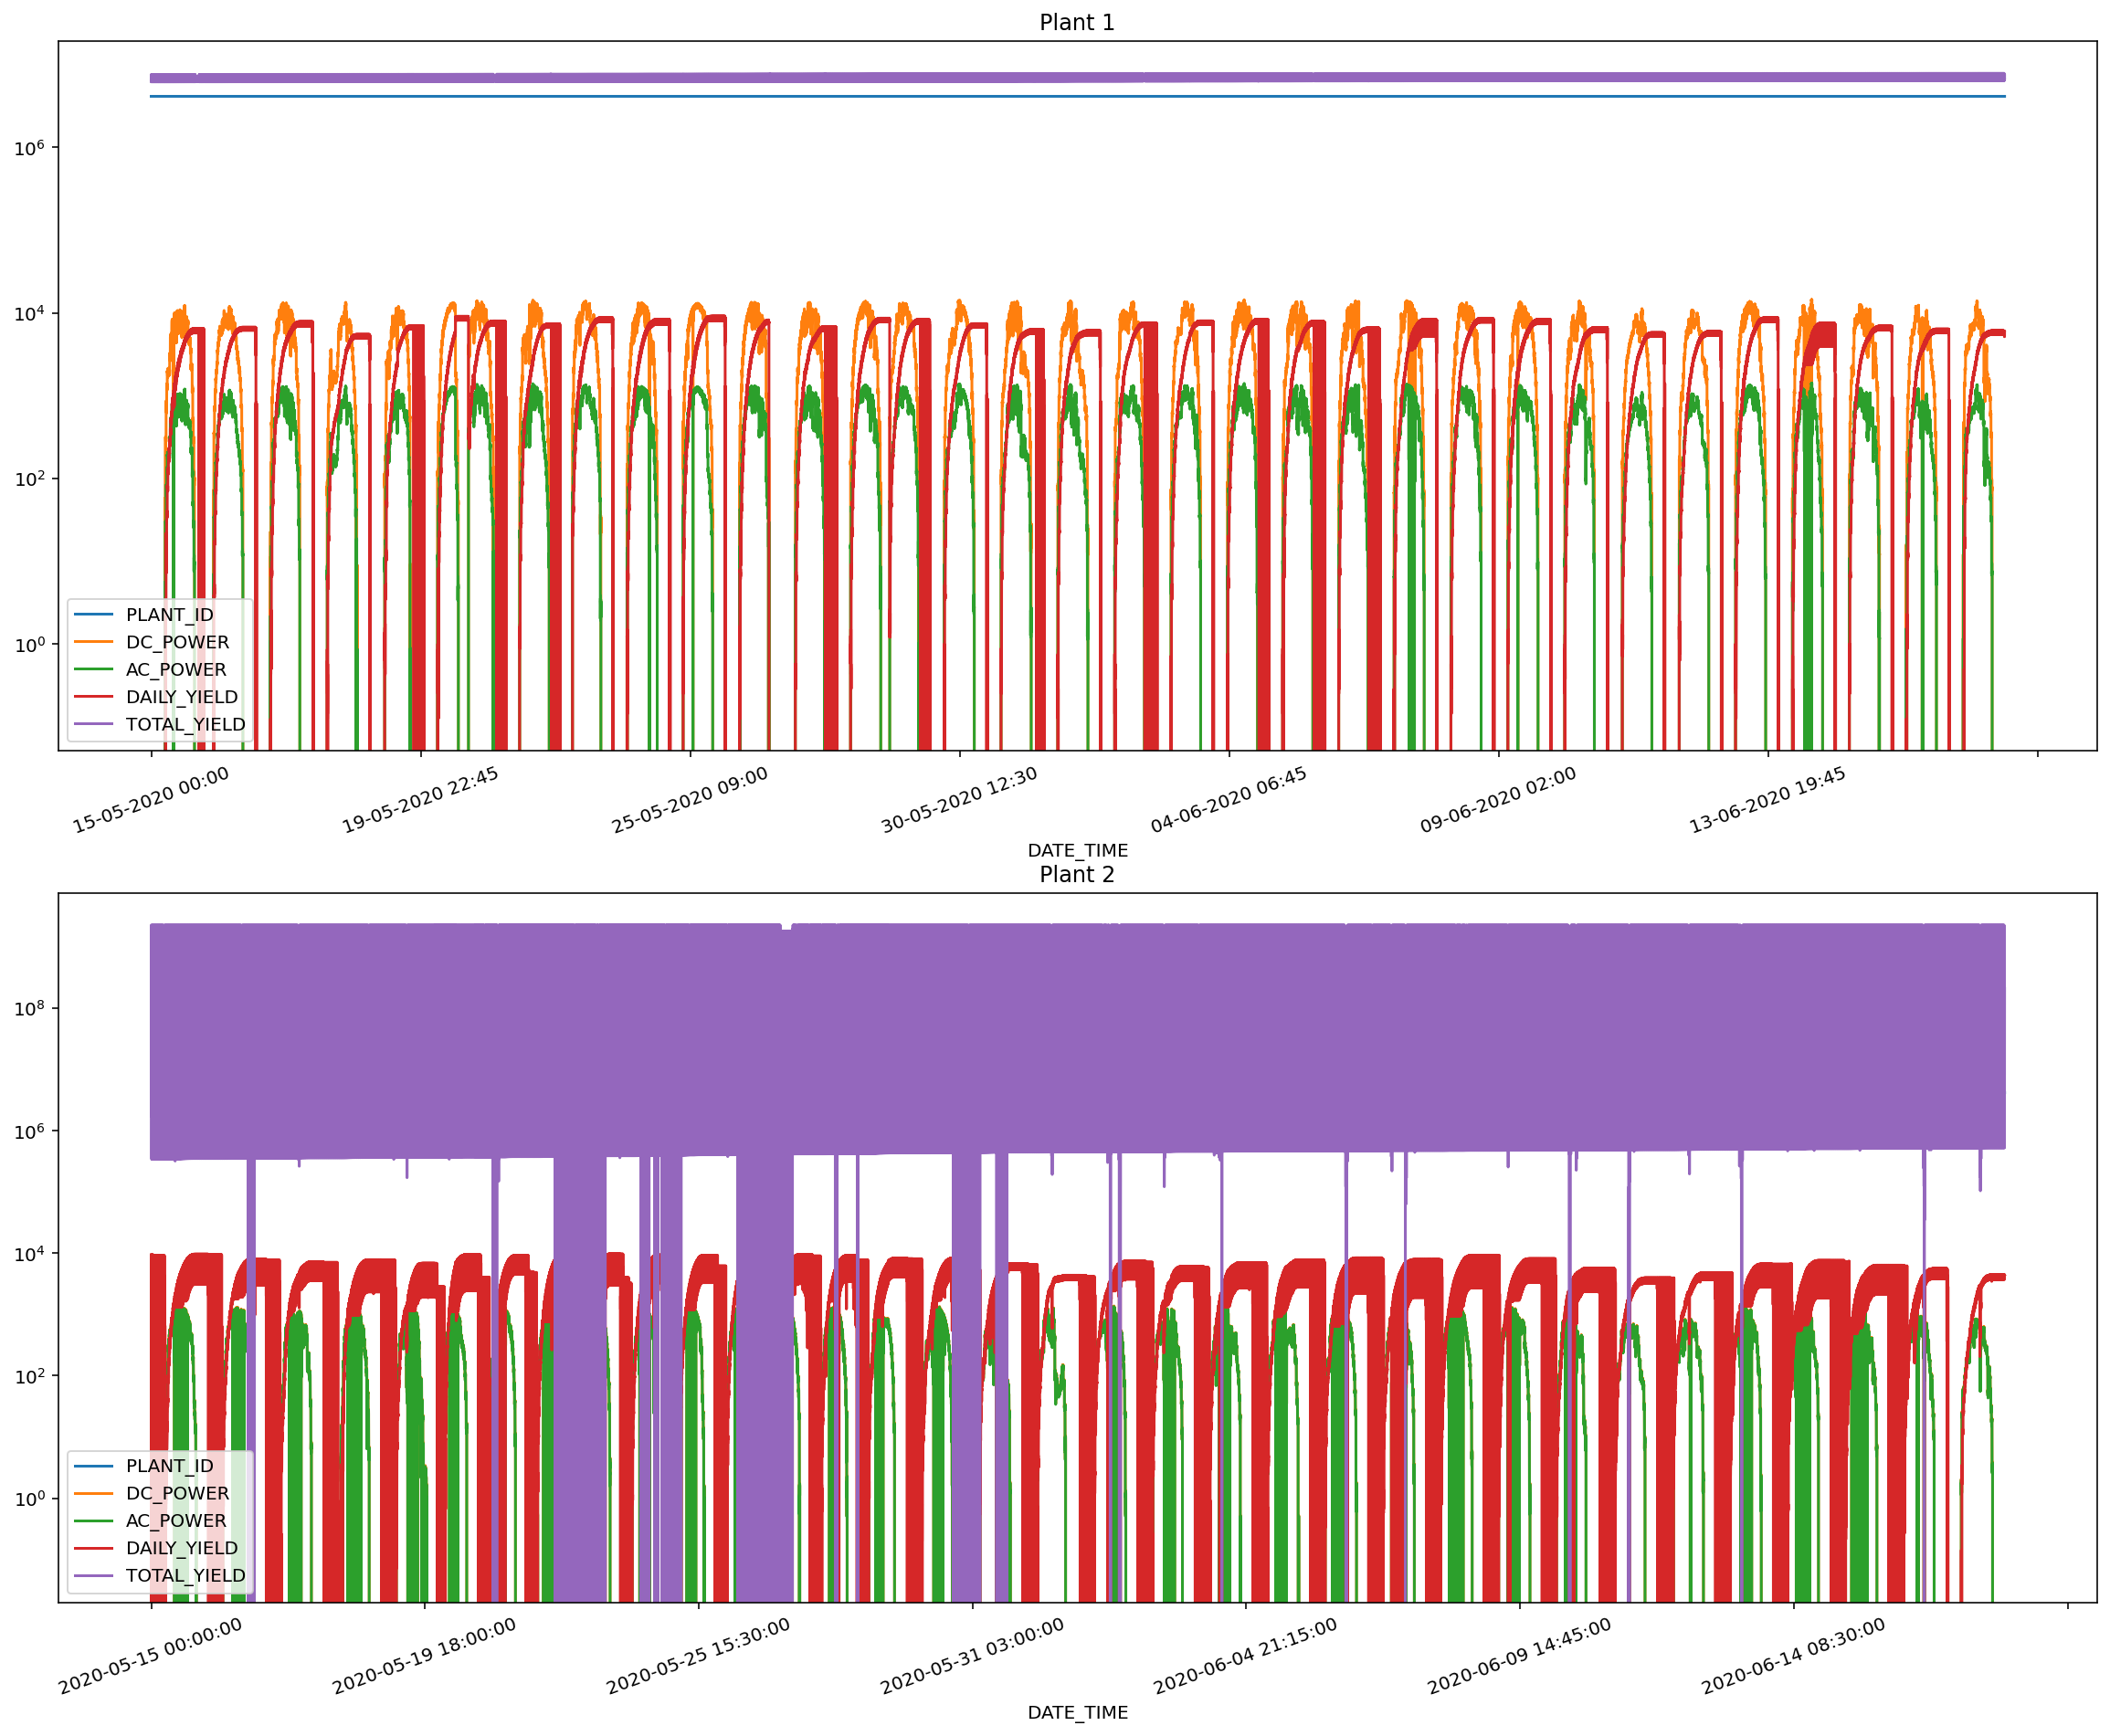

In [98]:
fig, axes = plt.subplots(nrows = 2, sharex=False, figsize=(20, 5))
fig.subplots_adjust(top = 2.5)
ax = plant1_generation.plot(x = 'DATE_TIME', logy = True, title = 'Plant 1', rot = 20, ax = axes[0]); 
ax = plant2_generation.plot(x = 'DATE_TIME', logy = True, title = 'Plant 2', rot = 20, ax = axes[1]); 

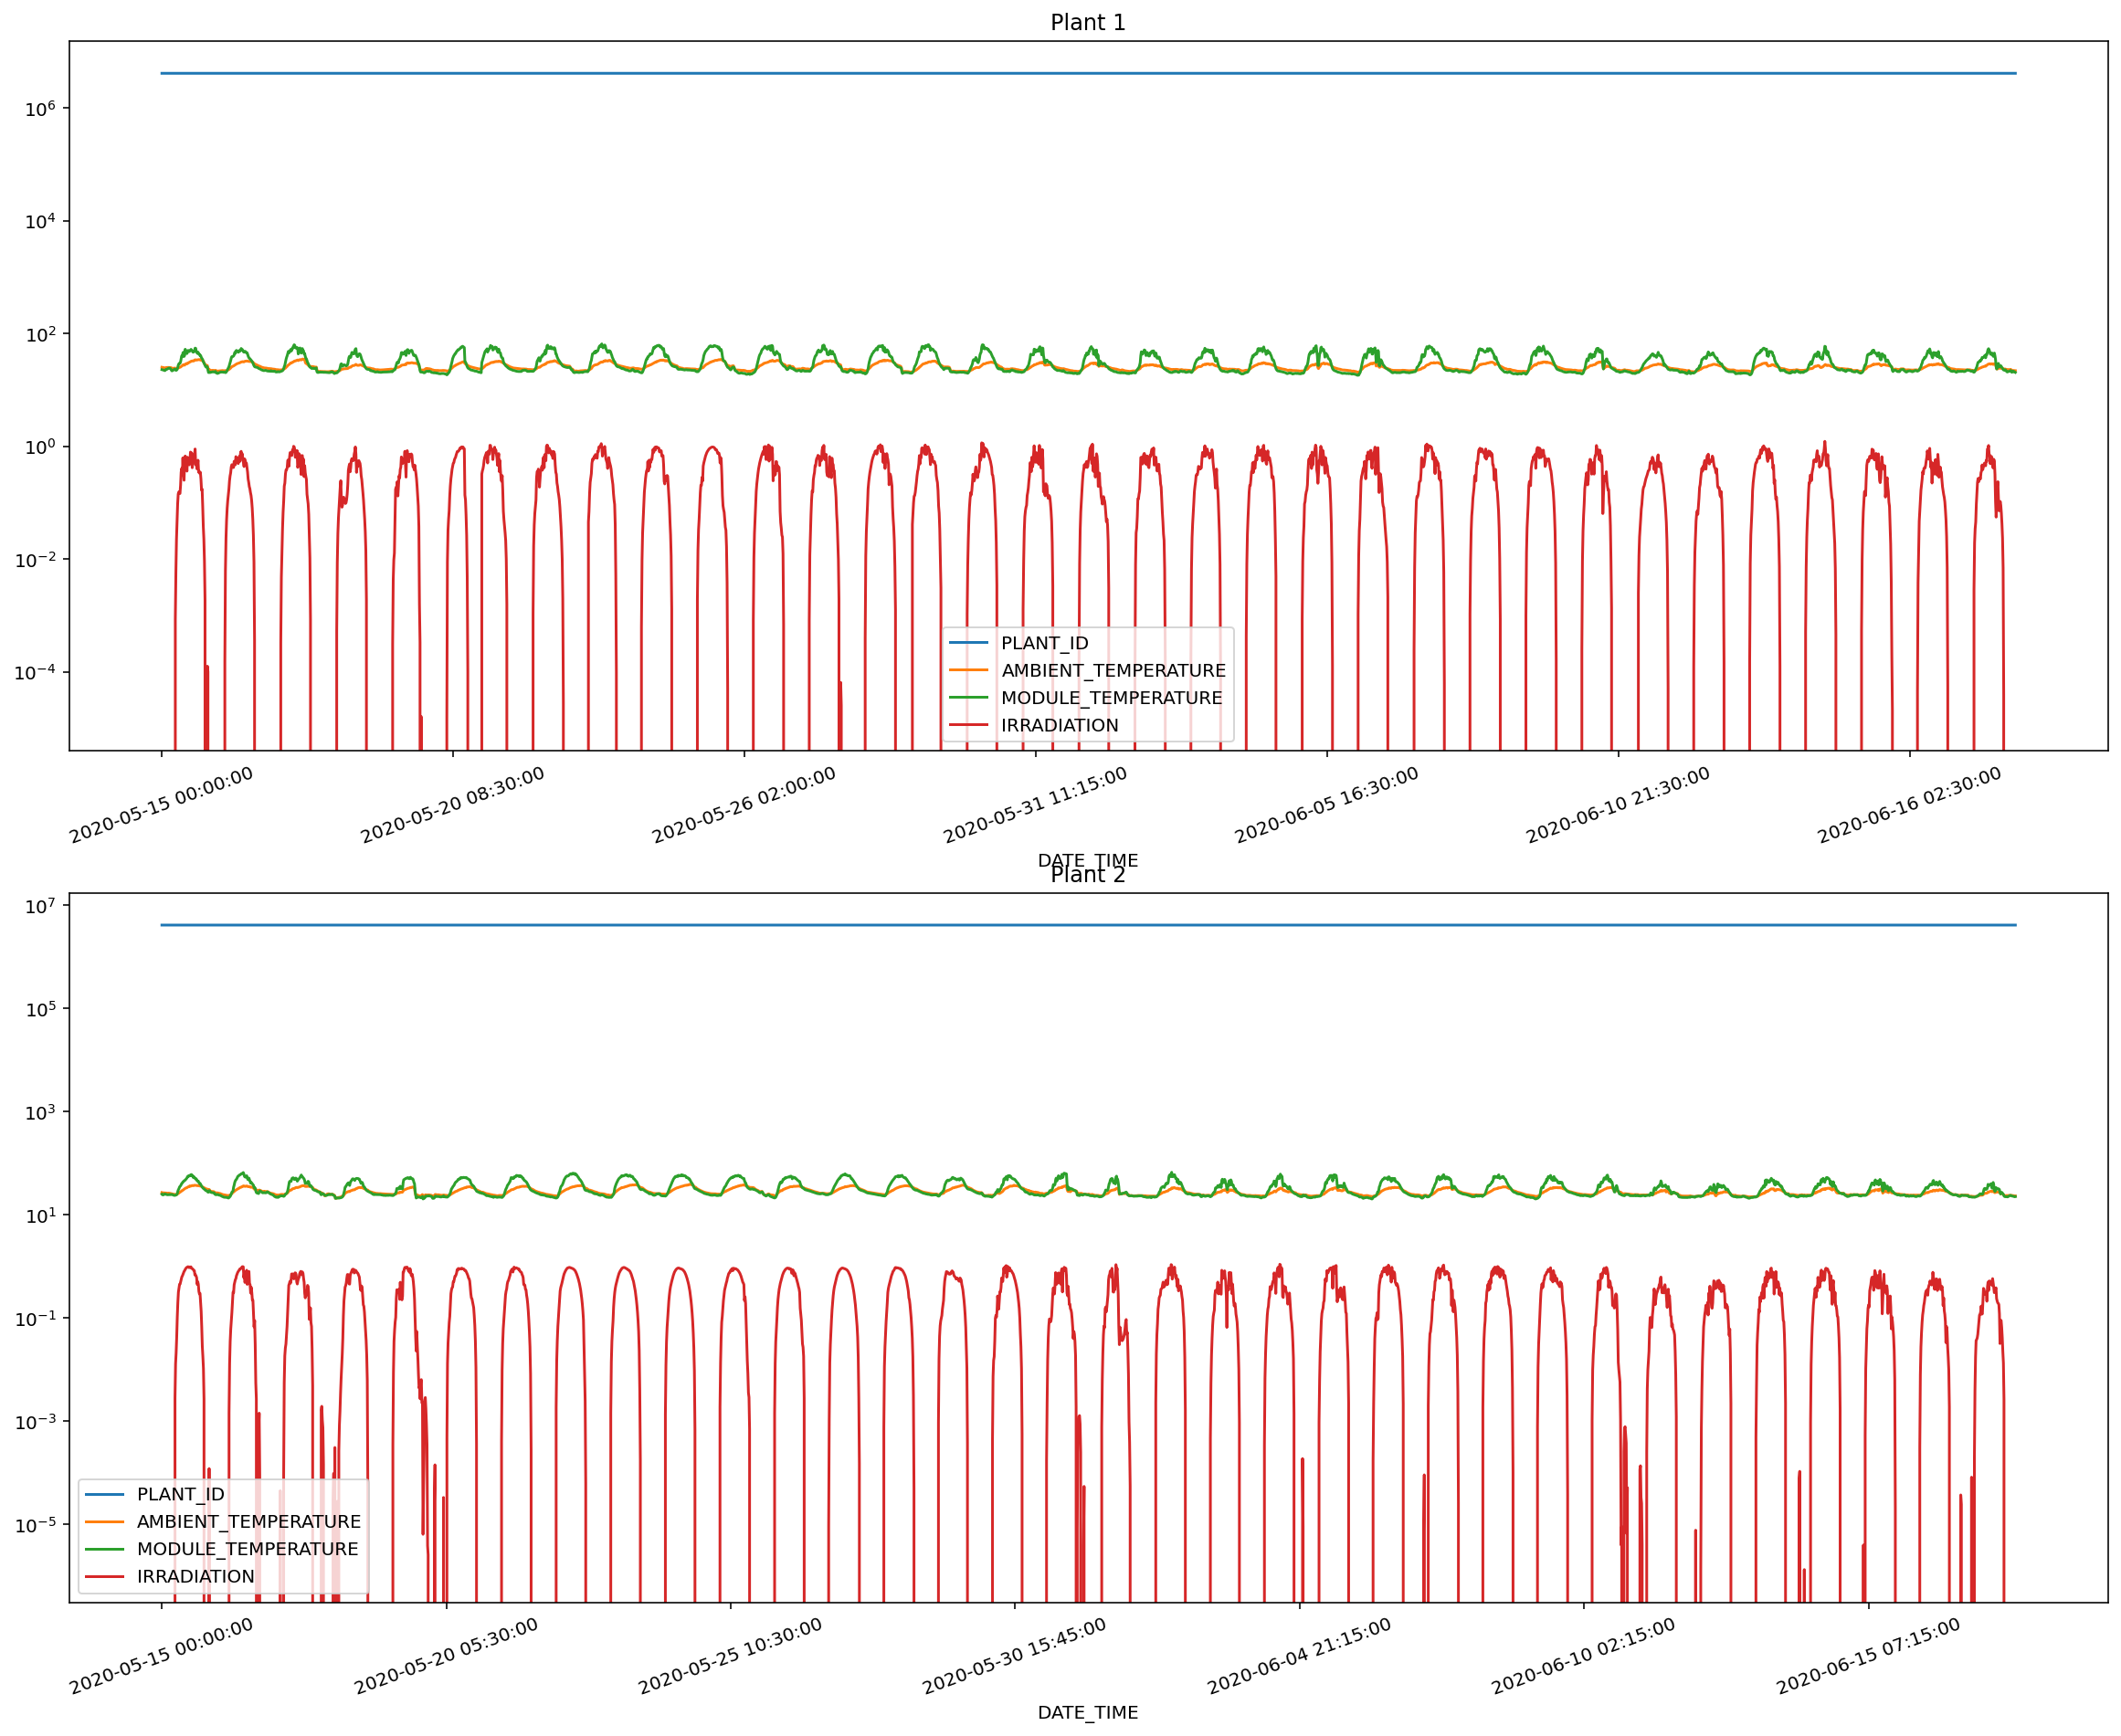

In [99]:
fig, axes = plt.subplots(nrows = 2, sharex=False, figsize=(20, 5))
fig.subplots_adjust(top = 2.6)
ax = plant1_weather.plot(x = 'DATE_TIME', logy = True, title = 'Plant 1', rot = 20, ax = axes[0]); 
ax = plant2_weather.plot(x = 'DATE_TIME', logy = True, title = 'Plant 2', rot = 20, ax = axes[1]); 

- From the plots above we see distinct peaks in power output, irradiation and temperature, rising and falling with the sun each day
- We can also see in the comparisons between plant 1 and plant 2, that for plant 1 TOTAL_YIELD is consistently > ~10^6 whilst for plant 2 TOTAL_YIELD varies dramatically with several interludes where it falls to zero and at other times in the 10^6 - >10^8 range. 
- Daily weather trends on the other hand appear superficially similar between plant 1 and plant 2

#### Lets looks at some aggreate values comparing the two plants

In [40]:
power_metrics =  plant1_generation.columns[3:]
weather_metrics = plant1_weather.columns[3:]

In [43]:
print(power_metrics)
print(weather_metrics)

Index(['DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD'], dtype='object')
Index(['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION'], dtype='object')


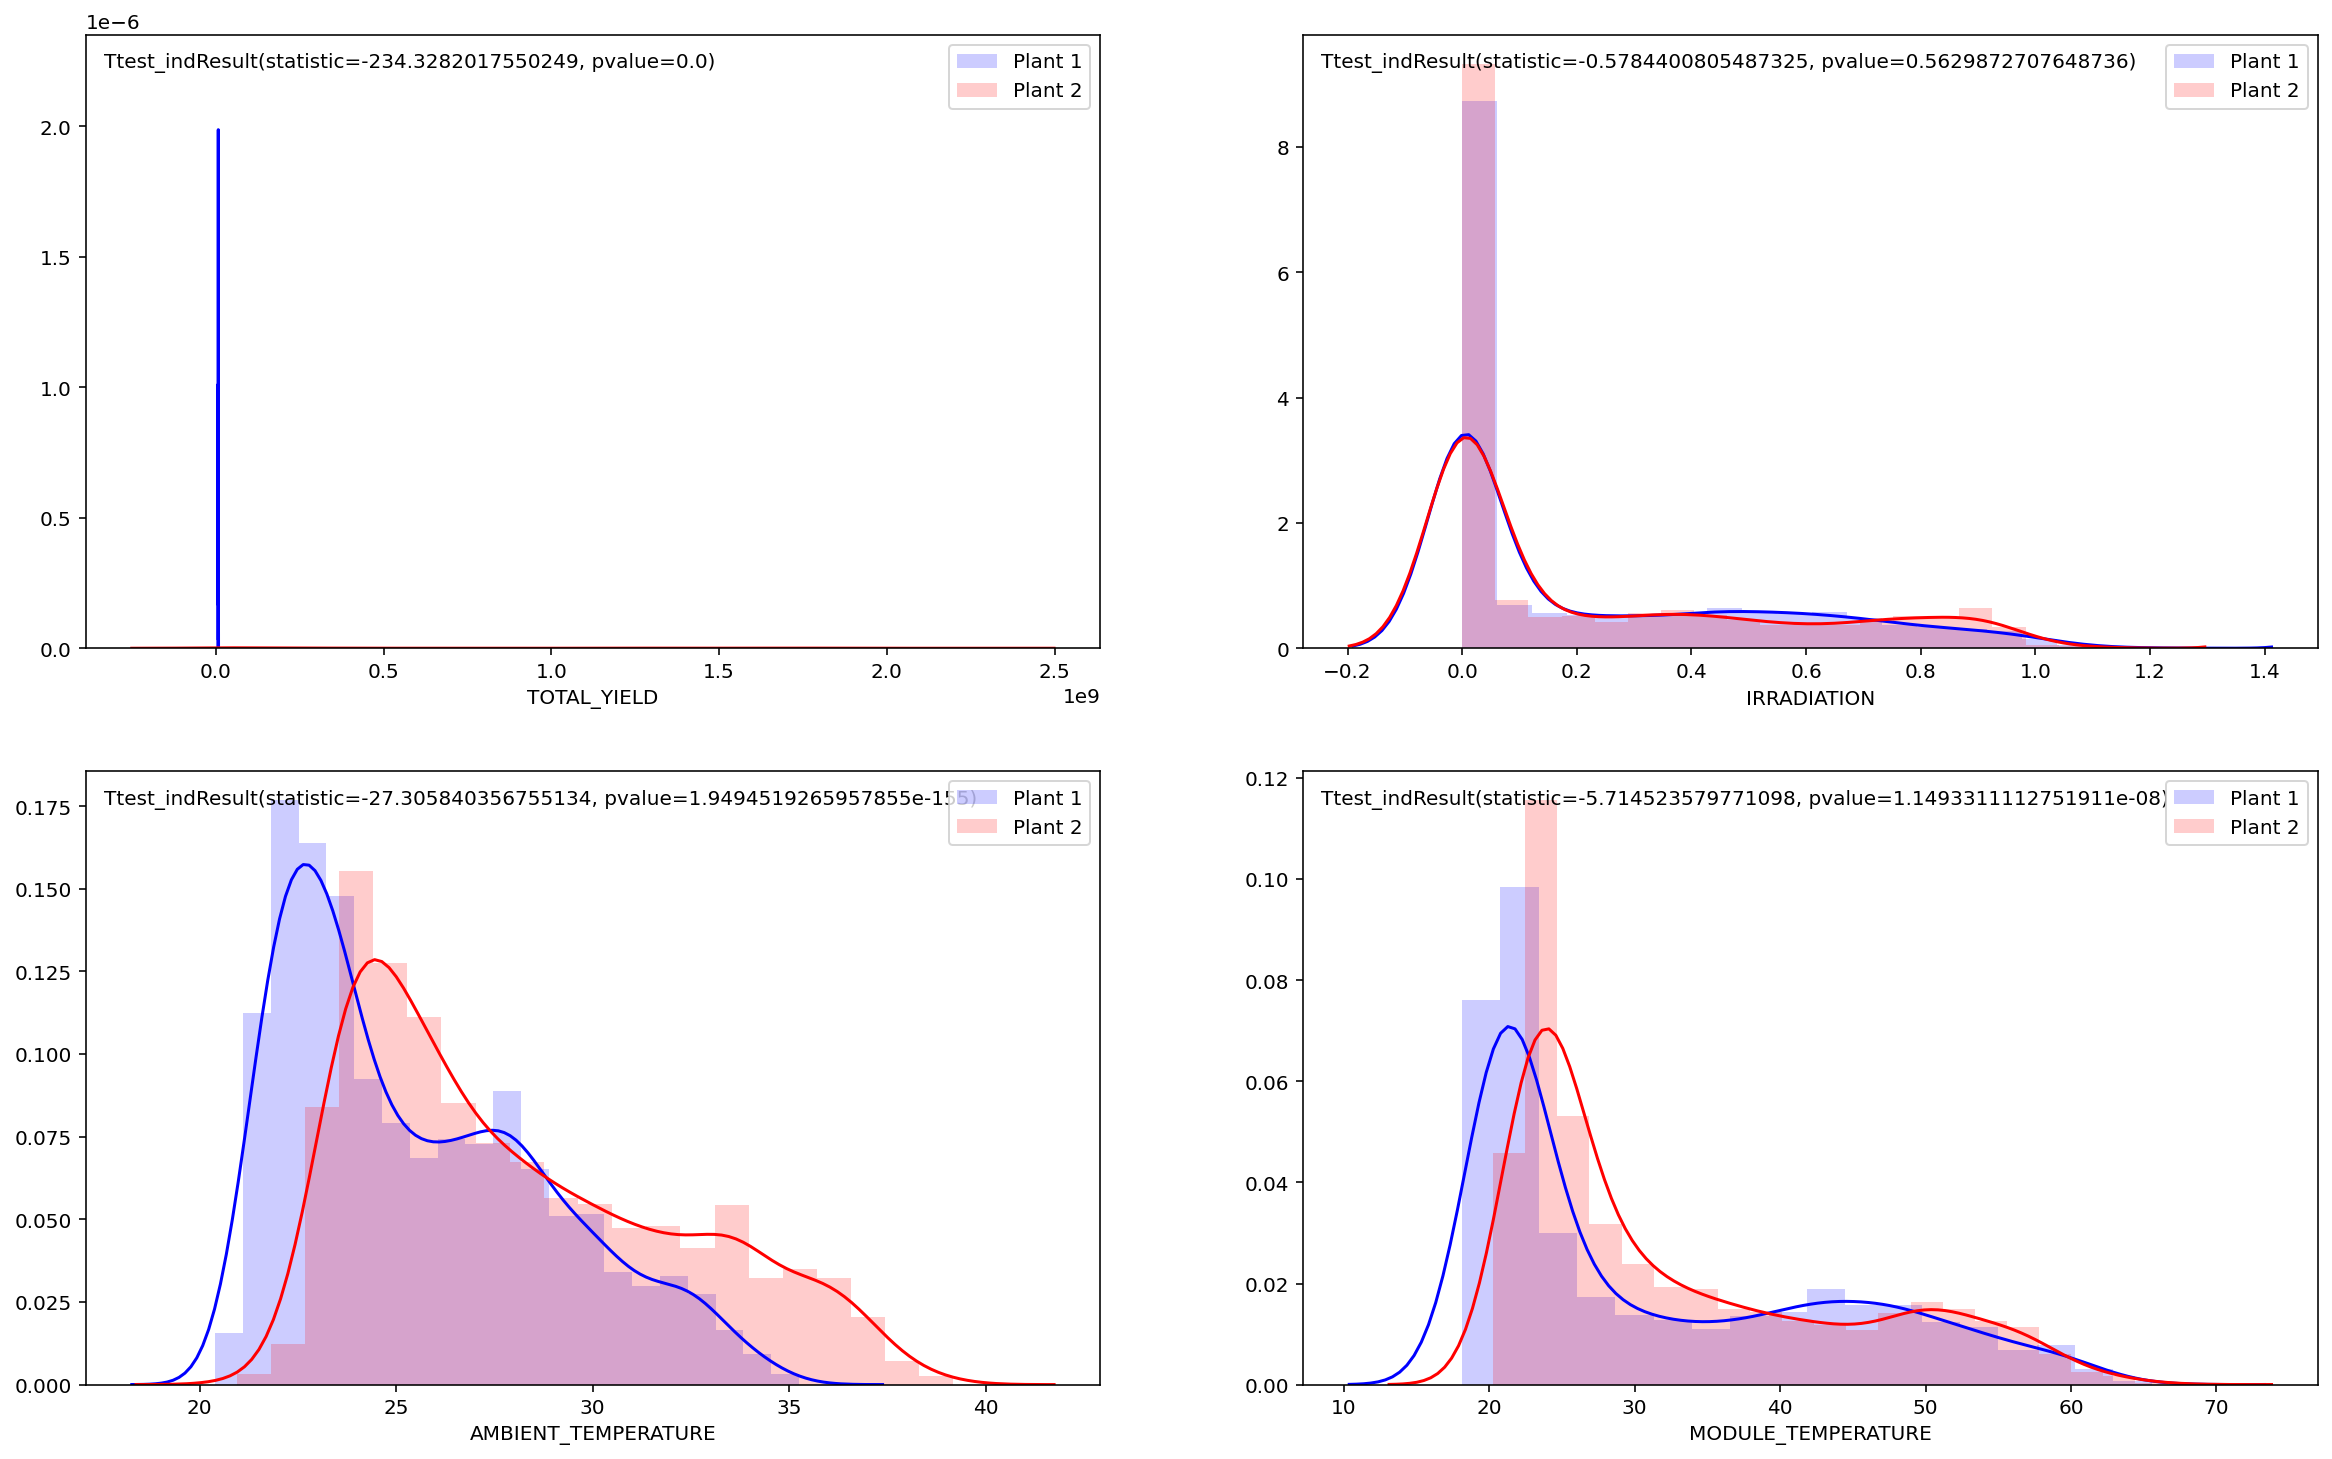

In [144]:
# Overlay of TOTAL_YIELD for plant 1 vs plant 2, with IRRADIATION for plant 1 vs plant 2 next to it
# ANOVA for both plant 1 v 2 comparisons below
from scipy import stats
from matplotlib.offsetbox import AnchoredText

TY_t = stats.ttest_ind(plant1_generation['TOTAL_YIELD'],plant2_generation['TOTAL_YIELD'])
IR_t = stats.ttest_ind(plant1_weather['IRRADIATION'],plant2_weather['IRRADIATION'])
AT_t = stats.ttest_ind(plant1_weather['AMBIENT_TEMPERATURE'],plant2_weather['AMBIENT_TEMPERATURE'])
MT_t = stats.ttest_ind(plant1_weather['MODULE_TEMPERATURE'],plant2_weather['MODULE_TEMPERATURE'])


fig, axes = plt.subplots(ncols = 2, nrows = 2, sharex=False, figsize=(20, 5))
fig.subplots_adjust(top = 2)

anc1 = AnchoredText(f"{TY_t}", loc="upper left", frameon=False)
ax1 = sns.distplot(plant1_generation['TOTAL_YIELD'], ax=axes[0,0], color = 'b', label = 'Plant 1', hist_kws=dict(alpha=0.2))
ax1 = sns.distplot(plant2_generation['TOTAL_YIELD'], ax=axes[0,0], color = 'r', label = 'Plant 2', hist_kws=dict(alpha=0.2))
ax1.add_artist(anc1)
ax1.legend()

anc2 = AnchoredText(f"{IR_t}", loc="upper left", frameon=False)
ax2 = sns.distplot(plant1_weather['IRRADIATION'], ax=axes[0,1], color = 'b', label = 'Plant 1', hist_kws=dict(alpha=0.2))
ax2 = sns.distplot(plant2_weather['IRRADIATION'], ax=axes[0,1], color = 'r', label = 'Plant 2', hist_kws=dict(alpha=0.2))
ax2.add_artist(anc2)
ax2.legend()

anc3 = AnchoredText(f"{AT_t}", loc="upper left", frameon=False)
ax3 = sns.distplot(plant1_weather['AMBIENT_TEMPERATURE'], ax=axes[1,0], color = 'b', label = 'Plant 1', hist_kws=dict(alpha=0.2))
ax3 = sns.distplot(plant2_weather['AMBIENT_TEMPERATURE'], ax=axes[1,0], color = 'r', label = 'Plant 2', hist_kws=dict(alpha=0.2))
ax3.add_artist(anc3)
ax3.legend()

anc4 = AnchoredText(f"{MT_t}", loc="upper left", frameon=False)
ax4 = sns.distplot(plant1_weather['MODULE_TEMPERATURE'], ax=axes[1,1], color = 'b', label = 'Plant 1', hist_kws=dict(alpha=0.2))
ax4 = sns.distplot(plant2_weather['MODULE_TEMPERATURE'], ax=axes[1,1], color = 'r', label = 'Plant 2', hist_kws=dict(alpha=0.2))
ax4.add_artist(anc4)
ax4.legend();

- From the distributions and t test results above we can see that the power outputs of the two plants are indeed very different
- In contrast, the levels of IRRADIATION, AMBIENT_TEMPERATURE and MODULE_TEMPERATURE between the two plants are similar though not identical, with IRRADIATION being most similar between the two sites
- Plant 2 has a warmer AMBIENT_TEMPERATURE and MODULE_TEMPERATURE on average. 
- Could these occasional days where ambient temperature rises above 35degC and the higher average module temperature, be the reason for the sporadic drops in power output from plant 2? Perhaps the equipment is over-heating causing it to be less reliable or fail when its operational temperature is exceeded?

# Forecasting Power Output With Facebook Prophet

# Anomaly Detection Using Gaussian Processes